In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout,LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1, l2
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Setup Data

In [17]:
data = pd.read_csv("../data/newEra.csv")

data.head()

,timeStamps,bufferSizes,bufferingStates,bufferingEvents,newBitrates,oldBitrates,resolutions,streamBandwidths,estimatedBandwidths
0,2024-09-18 02:27:43,1.0,1,5.290,2096000,1196000,960p,2.0,4.4
1,2024-09-18 02:27:46,1.0,1,6.509,2096000,1196000,960p,2.0,5.0
2,2024-09-18 02:27:47,1.0,0,6.509,2096000,1196000,960p,2.0,5.0
3,2024-09-18 02:27:48,1.0,0,6.509,2096000,1196000,960p,2.0,6.4
4,2024-09-18 02:27:49,1.0,0,6.509,2096000,1196000,960p,2.0,6.4


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1337 entries, 2024-09-18 02:27:43 to 2024-09-18 03:22:40
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bufferSizes          1337 non-null   float64
 1   bufferingStates      1337 non-null   int64  
 2   bufferingEvents      1337 non-null   float64
 3   newBitrates          1337 non-null   int64  
 4   oldBitrates          1337 non-null   int64  
 5   resolutions          1337 non-null   object 
 6   streamBandwidths     1337 non-null   float64
 7   estimatedBandwidths  1337 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 94.0+ KB


In [20]:
data['timeStamps'] = pd.to_datetime(data['timeStamps'])
data.dtypes
data.set_index('timeStamps', inplace=True)
data

,bufferSizes,bufferingStates,bufferingEvents,newBitrates,oldBitrates,resolutions,streamBandwidths,estimatedBandwidths
timeStamps,,,,,,,,
2024-09-18 02:27:43,1.0,1,5.290000,2096000,1196000,960p,2.0,4.4
2024-09-18 02:27:46,1.0,1,6.509000,2096000,1196000,960p,2.0,5.0
2024-09-18 02:27:47,1.0,0,6.509000,2096000,1196000,960p,2.0,5.0
2024-09-18 02:27:48,1.0,0,6.509000,2096000,1196000,960p,2.0,6.4
2024-09-18 02:27:49,1.0,0,6.509000,2096000,1196000,960p,2.0,6.4
...,...,...,...,...,...,...,...,...
2024-09-18 03:22:32,1.0,1,2009.692001,6096000,4596000,1920p,5.9,8.1
2024-09-18 03:22:33,0.5,0,2009.692001,6096000,4596000,1920p,5.9,8.4
2024-09-18 03:22:34,1.0,0,2009.692001,6096000,4596000,1920p,5.9,8.4


In [23]:
encoder = LabelEncoder()
data['resolutions'] = encoder.fit_transform(data['resolutions'])

In [61]:
features = data[["resolutions","estimatedBandwidths","streamBandwidths"]]
target = data['newBitrates']  # Target

In [62]:
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))
# Normalisasi data
train_features, test_features, train_target, test_target = train_test_split(
    features_scaled, target_scaled, test_size=0.2, shuffle=False,random_state=42)

print("train features",train_features.shape)
print("train target",train_target.shape)

train features (1069, 3)
train target (1069, 1)


In [63]:
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)



In [64]:
sequence_length = 10
X_train, y_train = create_sequences(train_features, train_target, sequence_length)
X_test, y_test = create_sequences(test_features, test_target, sequence_length)

In [65]:
print("X_train" ,X_train.shape)
print("y_train" ,y_train.shape)

print("X_test" ,X_test.shape)
print("y_test" ,y_test.shape)

X_train (1059, 10, 3)
y_train (1059, 1)
X_test (258, 10, 3)
y_test (258, 1)


In [66]:
def build_model(X_train):
     # Define the model
     model = Sequential()

# LSTM layer
     model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
     model.add(Dropout(0.2))

# LSTM layer kedua
     model.add(LSTM(units=50))
     model.add(Dropout(0.2))

# Output layer (regression)
     model.add(Dense(units=1))

# Compile the model
     model.compile(optimizer='adam', loss='mean_squared_error')
     model.summary()
     return model

In [67]:
model = build_model(X_train)

d:\cursor_code\python\Lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,435 (404.04 KB)

 Trainable params: 103,435 (404.04 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2260 - val_loss: 0.0087
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0501 - val_loss: 0.0047
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0465 - val_loss: 0.0069
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0415 - val_loss: 0.0176
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0402 - val_loss: 0.0113
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0408 - val_loss: 0.0058
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0378 - val_loss: 0.0043
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0323 - val_loss: 0.0195
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0326 - val_loss: 0.0037
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0356 - val_loss: 0.0086
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0360 - val_loss: 0.0042
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

In [69]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test)

# Predicting the test set results
y_pred = model.predict(X_test)
y_pred

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


array([[0.9855596 ],
       [0.9632397 ],
       [0.9580641 ],
       [0.9647087 ],
       [0.9626481 ],
       [0.97088575],
       [0.97325367],
       [0.968576  ],
       [0.96716094],
       [0.9094974 ],
       [0.93515754],
       [0.9537891 ],
       [0.9568939 ],
       [0.9560952 ],
       [0.9573282 ],
       [0.96011585],
       [0.9633573 ],
       [0.9664044 ],
       [0.9691861 ],
       [0.9691881 ],
       [0.98768723],
       [0.9660282 ],
       [0.91342396],
       [0.9396166 ],
       [0.96056986],
       [0.9650617 ],
       [0.9865512 ],
       [0.9469894 ],
       [0.9435293 ],
       [0.96275026],
       [0.9649499 ],
       [0.9664617 ],
       [0.96808755],
       [0.96817136],
       [0.96675164],
       [0.91074276],
       [0.93590075],
       [0.9536535 ],
       [0.9570323 ],
       [0.95689124],
       [0.36240822],
       [0.22541533],
       [0.2413655 ],
       [0.3134942 ],
       [0.3531772 ],
       [0.35739607],
       [0.6464511 ],
       [0.718

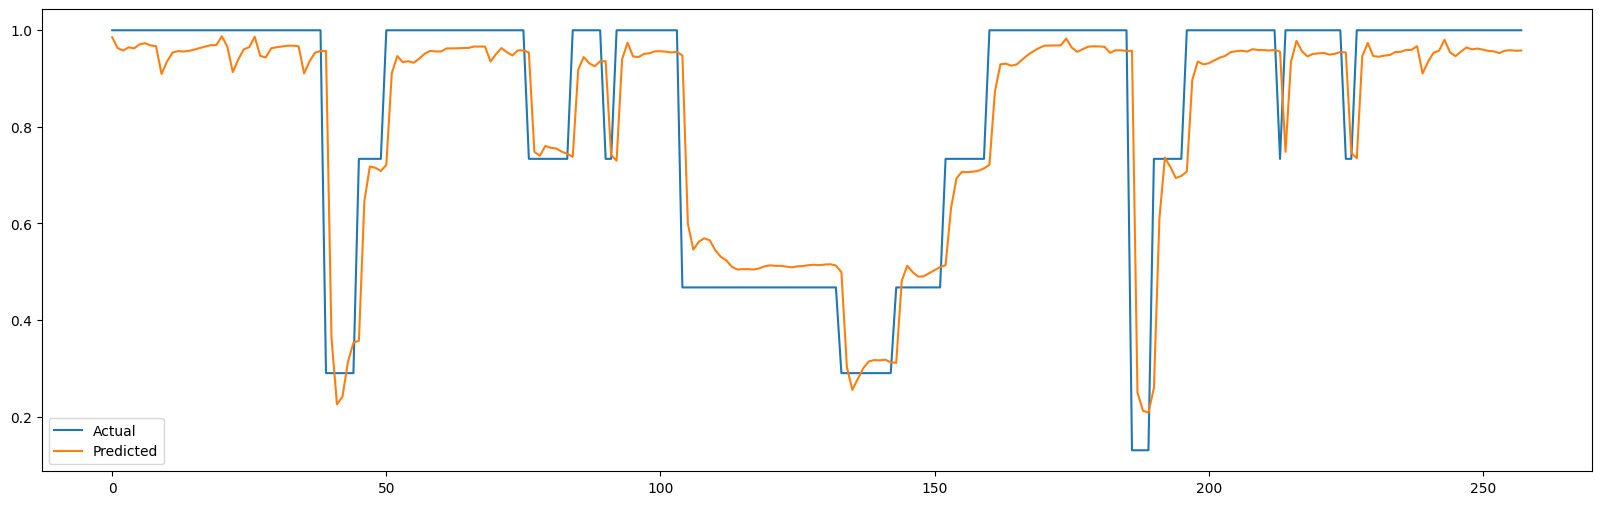

In [70]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [71]:
r2 = r2_score(y_test, y_pred)
r2

0.812303452616233

In [72]:
np.square(mean_squared_error(y_pred, y_test))


0.00014870277522084112